# LAD Custom experiment

Here we test the prediction quality regarding to the existence of spaces in word2vec model

In the original implementation the w2v model removes all the numbers and spaces in a log message and create a one single word:

`2019-04-12 01:13:20 [DEBUG] Processed 181 out of 181 packages` → `["DEBUGProcessedoutofpackages"]`

Here we want to test the original implementation and our approach:

`2019-04-12 01:13:20 [DEBUG] Processed 181 out of 181 packages` → `["DEBUG", "Processed", "out", "of", "packages"]`

### Import packages

In [1]:
import os
import time
import numpy as np
import logging
import sompy
from multiprocessing import Pool
from itertools import product
import pandas as pd
import re
import gensim as gs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt

CACHEDIR=/home/nadzya/.cache/matplotlib
Using fontManager instance from /home/nadzya/.cache/matplotlib/fontlist-v330.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
NumExpr defaulting to 4 threads.


In [2]:
# import logging

# logger = logging.getLogger()
# logger.disabled = True
# logging.disable()

# Original Approach

### Define Functions

#### 1. Log Preprocesing

One assumption that all these functions use is that we instantly convert our data into a pandas dataframe that has a "message" column containing the relevent information for us. 

**We then treat each individual log line as a "word", cleaning it by removing all non-alphabet charcters including white spaces.**

In [3]:
def _preprocess(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")
    
def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def to_str(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

#### 2. Text Encoding  

Here we employ the gensim implementation of Word2Vec to encode our logs as fixed length numerical vectors. Logs are noteably not the natural usecase for word2vec, but this appraoch attemps to leverage the fact that logs lines themselves, like words, have a context, so encoding a log based on its co-occurence with other logs does make some intuitive sense.

In [4]:
def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = gs.models.Word2Vec([list(words[col])], min_count=1, size=vector_length, 
                                     window=window_size, seed=42, workers=1, iter=550, sg=0)
        else:
            #_LOGGER.warning("Skipping key %s as it does not exist in 'words'" % col)
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)

#### 3. Model Training

Here we employ the SOMPY implementation of the Self-Organizing Map to train our model. This function simply makes it a bit easier for the user to interact with the sompy training requirements. This function returns a trained model.

The trained model object also has a method called codebook.matrix() which allows the user access directly to the trained self organizing map itself. If the map successfull converged then it should consist of nodes in our N-dimensional log space that are well ordered and provide an approximation to the topology of the logs in our training set.

During training we also, compute the distances of our training data to the trained map as a baseline to build a threashold.   

In [5]:
def train(inp, map_size, iterations, parallelism):
    print(f'training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    
    #distances = get_anomaly_score(inp, 8, model)
    #threshold = 3*np.std(distances) + np.mean(distances)
    
    return som #,threshold

#### 4. Generating Anomaly Scores

One of the key elements of this approach is quantifying the distance between our logs and the nodes on our self organizing map. The two functions below, taken together, represent a parrallel implementation for performing this calculaton.  

In [6]:
def get_anomaly_score(logs, parallelism, model):
    parameters = [[x, model] for x in logs]
    pool = Pool(parallelism)
    dist = pool.map(calculate_anomaly_score, parameters) 
    pool.close()
    pool.join()
    
    return dist

def calculate_anomaly_score(parameters):
    log = parameters[0]
    model = parameters[1]
    """Compute a distance of a log entry to elements of SOM."""
    dist_smallest = np.inf
    for x in range(model.shape[0]):
        for y in range(model.shape[1]):
            dist = cosine(model[x][y], log) 
            #dist = np.linalg.norm(model[x][y] - log)
            if dist < dist_smallest:
                dist_smallest = dist
    return dist_smallest

#### 5. Model Inference / Prediction

Here we are making an inference about a new log message. This is done by scoring the incoming log and evaluating whether or not it passess a certain threshold value.  


Ideally our word2vec has been monitoring our application long enough to have seen all the logs. So, if we get a known log we can simply look up its vector representation   

One downside with word2vec is that its quite brittle when it comes to incorporating words that haven't been seen before. In this example, we will retrain the W2Vmodel if our new log has not been seen by the before.  

In [7]:
def infer(w2v, som, log, data, threshold):
    
    log =  pd.DataFrame({"message":log},index=[1])
    _preprocess(log)
    
    if log.message.iloc[0] in list(w2v['message'].wv.vocab.keys()):
        vector = w2v["message"].wv[log.message.iloc[0]]
    else:
        w2v = gs.models.Word2Vec([[log.message.iloc[0]] + list(data["message"])], 
                                 min_count=1, size=25, window=3, seed=42, workers=1, iter=550, sg=0)
        vector = w2v.wv[log.message.iloc[0]]
    
    score = get_anomaly_score([vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score

## Implementation

### Get logs from file

In [207]:
data_path = r"file:///home/nadzya/Apps/log-anomaly-detector/validation_data/slx.json"
data = pd.DataFrame(pd.read_json(data_path, orient=str).message)
data

,message
0,"<189>date=2021-11-24 time=12:11:11 devname=""SL..."
1,"<190>date=2021-11-24 time=12:11:49 devname=""SL..."
2,"<189>date=2021-11-24 time=12:11:59 devname=""SL..."
3,"<189>date=2021-11-24 time=12:12:14 devname=""SL..."
4,"<189>date=2021-11-24 time=12:12:45 devname=""SL..."
...,...
9995,"<189>date=2021-11-25 time=15:17:00 devname=""SL..."
9996,"<189>date=2021-11-25 time=17:48:37 devname=""SL..."
9997,"<189>date=2021-11-25 time=18:32:31 devname=""SL..."
9998,"<189>date=2021-11-25 time=17:48:37 devname=""SL..."


### Preprocessing

In [208]:
preprocessed_data = data.copy()
_preprocess(preprocessed_data)

# First 5 prepocessed messages
pd.DataFrame(preprocessed_data.message).head()

,message
0,datetimedevnameSLXFGVMdevidFGVMlogidtypeevents...
1,datetimedevnameSLXFGVMdevidFGVMlogidtypeevents...
2,datetimedevnameSLXFGVMdevidFGVMlogidtypeevents...
3,datetimedevnameSLXFGVMdevidFGVMlogidtypeevents...
4,datetimedevnameSLXFGVMdevidFGVMlogidtypeevents...


Let's see how many logs are there for each preprocessed word-log. We display top 5

In [209]:
x = preprocessed_data.message.value_counts()
for i in x.keys()[:5]:
    print(i, x[i])

datetimedevnameSLXFGVMdevidFGVMlogidtypeeventsubtypesystemlevelinformationvdrooteventtimetzlogdescOutdatedreportfilesdeletedmsgDeleteoldreportfiles 711
datetimedevnameSLXFGVMdevidFGVMlogidtypeeventsubtypesystemlevelnoticevdrooteventtimetzlogdescSystemperformancestatisticsactionperfstatscpumemtotalsessiondiskbandwidthsetupratedisklogratefazlogratefreediskstoragesysuptimemsgPerformancestatisticsaverageCPUmemoryconcurrentsessionssetuprate 453
datetimedevnameSLXFGVMdevidFGVMlogidtypeutmsubtypevoipeventtypevoiplevelinformationvdrooteventtimetzsessionidepocheventidsrcipsrcportdstipdstportprotosrcintportdstintportpolicyidprofiledefaultvoipprotosipkindregisteractionpermitstatussucceededdurationdirsessionorigincallidafabaeccbfromsipsiptelecombytosipsiptelecomby 217
datetimedevnameSLXFGVMdevidFGVMlogidtypeeventsubtypesystemlevelinformationvdrooteventtimetzlogdescAdminlogoutsuccessfulsnuserADMINuisshmethodsshsrcipdstipactionlogoutstatussuccessdurationreasonexitmsgAdministratorADMINloggedoutfromss

### Word2Vec for such words

In [210]:
w2v = create(words=preprocessed_data, vector_length=25, window_size=5)

In [211]:
log_vectors = one_vector(preprocessed_data, w2v)

In [212]:
print(log_vectors.shape)
print(log_vectors[:, 1:].shape)
log_vectors = log_vectors[:, 1:]

(10000, 26)
(10000, 25)


### Train SOM

In [213]:
map_size = 24
som = train(log_vectors, map_size=map_size, iterations=0, parallelism=2)

training dataset is of size 10000


In [214]:
model = som.codebook.matrix.reshape([map_size, map_size, log_vectors.shape[1]])

In [215]:
model.shape

(24, 24, 25)

In [216]:
anomaly_scores = get_anomaly_score(log_vectors, parallelism=4, model=model)

In [217]:
threshold = 3*np.std(anomaly_scores) + np.mean(anomaly_scores)
threshold

0.6289707291365374

# With Custom Approach

### Define Functions

#### 1. Log Preprocesing

One assumption that all these functions use is that we instantly convert our data into a pandas dataframe that has a "message" column containing the relevent information for us. 

We then treat each individual log line as a set of words, cleaning it by removing all non-alphabet charcters.

We keep white spaces and return a list of wordss

In [218]:
def _preprocess_custom(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message_custom)
        else:
            data[col] = data[col].apply(to_str_custom)

    data = data.fillna("EMPTY")
    
def _clean_message_custom(line):
    """Remove all none alphabetical characters from message strings."""
    words = list(re.findall("[a-zA-Z]+", line))
    return words

def to_str_custom(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

#### Text encoding

In [219]:
def create_custom(logs, vector_length, window_size):
    """Create new word2vec model."""
    model = gs.models.Word2Vec(sentences=list(logs), size=vector_length, window=window_size)
    return model

def get_vectors(model, logs, vector_length):
    """Return logs as list of vectorized words"""
    vectors = []
    for x in logs:
        temp = []
        for word in x:
            if word in model.wv:
                temp.append(model.wv[word])
            else:
                temp.append(np.array([0]*vector_length))
        vectors.append(temp)
    return vectors

def _log_words_to_one_vector(log_words_vectors):
        result = []
        log_array_transposed = np.array(log_words_vectors, dtype=object).transpose()
        for coord in log_array_transposed:
            result.append(np.mean(coord))
        return result

def vectorized_logs_to_single_vectors(vectors):
    """Represent log messages as vectors according to the vectors
    of the words in these logs

    :params vectors: list of log messages, represented as list of words vectors
            [[wordvec11, wordvec12], [wordvec21, wordvec22], ...]
    """
    result = []
    for log_words_vector in vectors:
        result.append(_log_words_to_one_vector(log_words_vector))
    return np.array(result)

**LOF for training**

In [220]:
def train_lof(X, eps, min_samples):
    lof = LocalOutlierFactor(metric='euclidean')
    pred = lof.fit_predict(X)
    lof_model = LocalOutlierFactor(metric='euclidean', novelty=True)
    lof_model.fit(X)
    return pred, lof_model

#### Prediction

In [221]:
def infer_custom(w2v, som, log, logs_list, threshold):
    
    log = pd.DataFrame({"message": log}, index=[1])
    _preprocess_custom(log)
    
    vector = []
    w2v = gs.models.Word2Vec([log.message.iloc[0]] + logs_list,
                             min_count=1, size=25, window=5)
    for word in log.message.iloc[0]:
        if word in w2v.wv.vocab.keys():
            vector.append(w2v.wv[word])
        else:
            vector.append(np.array([0]*25))
    
    one_vector = _log_words_to_one_vector(vector)
    
    score = get_anomaly_score([one_vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score

In [222]:
def infer_lof(w2v, lof, log, loglist):
    log = pd.DataFrame({"message": log}, index=[1])
    _preprocess_custom(log)
    
    vector = []
    w2v = gs.models.Word2Vec([log.message.iloc[0]] + logs_list,
                             min_count=1, size=25, window=5)
    for word in log.message.iloc[0]:
        if word in w2v.wv.vocab.keys():
            vector.append(w2v.wv[word])
        else:
            vector.append(np.array([0]*25))
    one_vector = _log_words_to_one_vector(vector)
    pred = lof.predict([one_vector])
    score = abs(lof.score_samples([one_vector])[0])
    if pred[0] == -1:
        return 1, score
    return 0, score

## Implementation

### Preprocessing

In [223]:
custom_preproc_data = data.copy()
_preprocess_custom(custom_preproc_data)

# First 5 prepocessed messages
pd.DataFrame(custom_preproc_data.message).head()

,message
0,"[date, time, devname, SLX, FG, VM, devid, FGVM..."
1,"[date, time, devname, SLX, FG, VM, devid, FGVM..."
2,"[date, time, devname, SLX, FG, VM, devid, FGVM..."
3,"[date, time, devname, SLX, FG, VM, devid, FGVM..."
4,"[date, time, devname, SLX, FG, VM, devid, FGVM..."


In [224]:
logs_list = list(custom_preproc_data.message)
logs_list[0]

['date',
 'time',
 'devname',
 'SLX',
 'FG',
 'VM',
 'devid',
 'FGVM',
 'logid',
 'type',
 'event',
 'subtype',
 'vpn',
 'level',
 'notice',
 'vd',
 'root',
 'eventtime',
 'tz',
 'logdesc',
 'Progress',
 'IPsec',
 'phase',
 'msg',
 'progress',
 'IPsec',
 'phase',
 'action',
 'negotiate',
 'remip',
 'locip',
 'remport',
 'locport',
 'outintf',
 'port',
 'cookies',
 'ddabf',
 'c',
 'user',
 'N',
 'A',
 'group',
 'N',
 'A',
 'useralt',
 'N',
 'A',
 'xauthuser',
 'N',
 'A',
 'xauthgroup',
 'N',
 'A',
 'assignip',
 'N',
 'A',
 'vpntunnel',
 'test',
 'status',
 'success',
 'init',
 'local',
 'mode',
 'main',
 'dir',
 'outbound',
 'stage',
 'role',
 'initiator',
 'result',
 'OK']

In [225]:
w2v_custom = create_custom(logs_list, vector_length=25, window_size=5)

In [226]:
vectors_custom = get_vectors(model=w2v_custom, logs=logs_list, vector_length=25)

In [227]:
logs_as_vectors = vectorized_logs_to_single_vectors(vectors_custom)

### Train SOM

In [228]:
map_size = 24
som_custom = train(logs_as_vectors, map_size=map_size, iterations=0, parallelism=2)

training dataset is of size 10000


In [229]:
model_custom = som_custom.codebook.matrix.reshape([map_size, map_size, logs_as_vectors.shape[1]])

In [230]:
anomaly_scores_custom = get_anomaly_score(logs_as_vectors, parallelism=4, model=model_custom)

In [231]:
threshold_custom = 3*np.std(anomaly_scores_custom) + np.mean(anomaly_scores_custom)
threshold_custom

0.5282497051104771

In [254]:
labeled_data_som = data.copy()
labeled_data_som["score"] = anomaly_scores_custom
list(labeled_data_som.loc[labeled_data_som["score"] > threshold_custom]["message"])

[]

### Train LOF

In [233]:
clusters_lof, lof_model = train_lof(logs_as_vectors, 0.5, 10)

In [273]:
labeled_data = data.copy()
labeled_data["cluster"] = clusters_lof
labeled_data["score"] = abs(lof_model.score_samples(logs_as_vectors))
list(zip(labeled_data.loc[labeled_data["cluster"] == -1]["message"], labeled_data.loc[labeled_data["cluster"] == -1]["score"]))

[('<189>date=2021-11-24 time=12:11:11 devname="SLX-FG-VM-166" devid="FGVM010000010982" logid="0101037127" type="event" subtype="vpn" level="notice" vd="root" eventtime=1637745072926351051 tz="+0300" logdesc="Progress IPsec phase 1" msg="progress IPsec phase 1" action="negotiate" remip=172.17.42.203 locip=172.17.42.1 remport=500 locport=500 outintf="port5" cookies="81ddabf5934c2569/0000000000000000" user="N/A" group="N/A" useralt="N/A" xauthuser="N/A" xauthgroup="N/A" assignip=N/A vpntunnel="test" status="success" init="local" mode="main" dir="outbound" stage=1 role="initiator" result="OK"',
  128385420.87165335),
 ('<189>date=2021-11-24 time=12:13:15 devname="SLX-FG-VM-166" devid="FGVM010000010982" logid="0101037127" type="event" subtype="vpn" level="notice" vd="root" eventtime=1637745196931875929 tz="+0300" logdesc="Progress IPsec phase 1" msg="progress IPsec phase 1" action="negotiate" remip=172.17.42.203 locip=172.17.42.1 remport=500 locport=500 outintf="port5" cookies="da2479fd7733

In [256]:
abs(lof_model.score_samples([logs_as_vectors[0]]))

array([1.28385421e+08])

# Prediciton

In [235]:
import logging

logger = logging.getLogger()
logger.disabled = True
logging.disable()

**This is a test message**

In [236]:
infer(w2v, model, "Blah blah blah blah blah", preprocessed_data, threshold)

(0, [0.48561423554748295])

In [237]:
infer_custom(w2v_custom, model_custom, "Blah blah blah blah blah", logs_list, threshold_custom)

(0, [0.2507441584059752])

In [238]:
infer_lof(w2v_custom, lof_model, "Blah blah blah blah blah", logs_list)

(1, 25071636173.20911)

**<182>Dec 07 14:16:16 dataform  172.17.17.100 - - [07/Dec/2021:14:16:16 +0300] "POST /cgi-bin/.%2e/.%2e/.%2e/.%2e/etc/passwd HTTP/1.1" 400 5604 "-" "curl/7.68.0"**

In [239]:
infer(w2v, model, "<182>Dec 07 14:16:16 www.solidex.by  172.17.17.100 - - [07/Dec/2021:14:16:16 +0300] \"POST /cgi-bin/.%2e/.%2e/.%2e/.%2e/etc/passwd HTTP/1.1\" 400 5604 \"-\" \"curl/7.68.0\"", preprocessed_data, threshold)

(0, [0.4637601312927012])

In [240]:
infer_custom(w2v_custom, model_custom, "<182>Dec 07 14:16:16 www.solidex.by  172.17.17.100 - - [07/Dec/2021:14:16:16 +0300] \"POST /cgi-bin/.%2e/.%2e/.%2e/.%2e/etc/passwd HTTP/1.1\" 400 5604 \"-\" \"curl/7.68.0\"", logs_list, threshold_custom)

(0, [0.29412627641540645])

In [241]:
infer_lof(w2v_custom, lof_model, "<182>Dec 07 14:16:16 www.solidex.by  172.17.17.100 - - [07/Dec/2021:14:16:16 +0300] \"POST /cgi-bin/.%2e/.%2e/.%2e/.%2e/etc/passwd HTTP/1.1\" 400 5604 \"-\" \"curl/7.68.0\"", logs_list)

(1, 32078609239.911613)

In [242]:
infer_lof(w2v_custom, lof_model, "<158>Nov 25 12:25:32 195-137-160-145 nginx-access 80.94.224.36 - - [25/Nov/2021:12:25:30 +0300] \"GET / HTTP/1.1\" 200 3717 \"-\" \"Go-http-client/1.1\"", logs_list)

(1, 137.1516606405176)

**<179>Dec 07 14:51:17 dataform  [Wed Dec 07 14:51:17.120946 2021] [auth_basic:error] [pid 2179734:tid 139663791892224] [client 172.17.17.100:44992] AH01617: user webadmin: authentication failure for "/register": Password Mismatch***

In [243]:
infer(w2v, model, "<179>Dec 07 14:51:17 www.solidex.by  [Wed Dec 07 14:51:17.120946 2021] [auth_basic:error] [pid 2179734:tid 139663791892224] [client 172.17.17.100:44992] AH01617: user webadmin: authentication failure for \"/register\": Password Mismatch", preprocessed_data, threshold)

(0, [0.47687964837695906])

In [244]:
infer_custom(w2v_custom, model_custom, "<179>Dec 07 14:51:17 www.solidex.by  [Wed Dec 07 14:51:17.120946 2021] [auth_basic:error] [pid 2179734:tid 139663791892224] [client 172.17.17.100:44992] AH01617: user webadmin: authentication failure for \"/register\": Password Mismatch", logs_list, threshold_custom)

(0, [0.385474067188481])

In [245]:
infer_lof(w2v_custom, lof_model, "<179>Dec 07 14:51:17 www.solidex.by  [Wed Dec 07 14:51:17.120946 2021] [auth_basic:error] [pid 2179734:tid 139663791892224] [client 172.17.17.100:44992] AH01617: user webadmin: authentication failure for \"/register\": Password Mismatch", logs_list,)

(1, 26283877166.873466)

**<179>Dec 07 12:10:53 smtplib.SMTPRecipientsRefused: {'doesntexist@solidex.by': (550, b'5.1.1 <doesntexist@solidex.by>: Recipient address rejected: User unknown in virtual mailbox table')}**

In [246]:
infer(w2v, model, "<179>Dec 07 12:10:53 smtplib.SMTPRecipientsRefused: {'doesntexist@solidex.by': (550, b'5.1.1 <doesntexist@solidex.by>: Recipient address rejected: User unknown in virtual mailbox table')}", preprocessed_data, threshold)

(0, [0.48235160654274833])

In [247]:
infer_custom(w2v_custom, model_custom, "<179>Dec 07 12:10:53 smtplibb.SMTPRecipientsRefused: {'doesntexist@solidex.by': (550, b'5.1.1 <doesntexist@solidex.by>: Recipient address rejected: User unknown in virtual mailbox table')}", logs_list, threshold_custom)

(0, [0.3368861524426813])

In [248]:
infer_lof(w2v_custom, lof_model, "<179>Dec 07 12:10:53 smtplibb.SMTPRecipientsRefused: {'doesntexist@solidex.by': (550, b'5.1.1 <doesntexist@solidex.by>: Recipient address rejected: User unknown in virtual mailbox table')}", logs_list)

(1, 25813979135.517998)

**<158>Dec 07 14:24:59 195-137-160-145 nginx-access 2021/11/25 14:24:56 [error] 492#492: *15416147 open() "/var/www/solidex.by/public_html/robots.txt" failed (2: No such file or directory), client: 216.244.66.231, server: , request: "GET /robots.txt HTTP/1.1", host: solidex.by**

In [249]:
infer(w2v, model, "<158>Dec 07 14:24:59 195-137-160-145 nginx-access 2021/11/25 14:24:56 [error] 492#492: *15416147 open() \"/var/www/solidex.by/public_html/robots.txt\" failed (2: No such file or directory), client: 216.244.66.231, server: , request: \"GET /robots.txt HTTP/1.1\", host: \"solidex.by\"", preprocessed_data, threshold)

(0, [0.4917234675192519])

In [250]:
infer_custom(w2v_custom, model_custom, "<158>Dec 07 14:24:59 195-137-160-145 nginx-access 2021/11/25 14:24:56 [error] 492#492: *15416147 open() \"/var/www/solidex.by/public_html/robots.txt\" failed (2: No such file or directory), client: 216.244.66.231, server: , request: \"GET /robots.txt HTTP/1.1\", host: \"solidex.by\"", logs_list, threshold_custom)

(0, [0.40948715713801476])

# Visualization

In [251]:
from sklearn.decomposition import PCA

### LOF

Populating the interactive namespace from numpy and matplotlib


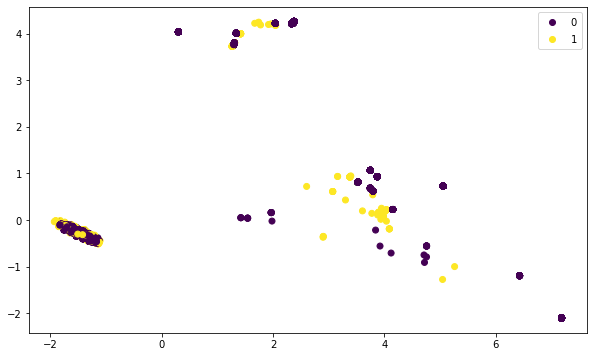

In [252]:
%pylab inline

outliers = []
for x in clusters_lof:
    if x == -1:
        outliers.append(1)
    else:
        outliers.append(0)

pca = PCA(n_components=2, random_state=0)
data_2d_pca = pca.fit_transform(logs_as_vectors)

scores = lof_model.negative_outlier_factor_
radius = (scores.max() - scores) / (scores.max() - scores.min())

pylab.figure(figsize=(10, 6))
scat = pylab.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], c=outliers)
pylab.legend(*scat.legend_elements(num='auto'))
# plt.scatter(
#     data_2d_pca[:, 0],
#     data_2d_pca[:, 1],
#     s=1000 * radius,
#     edgecolors="r",
#     facecolors="none"
# )

### W2V custom

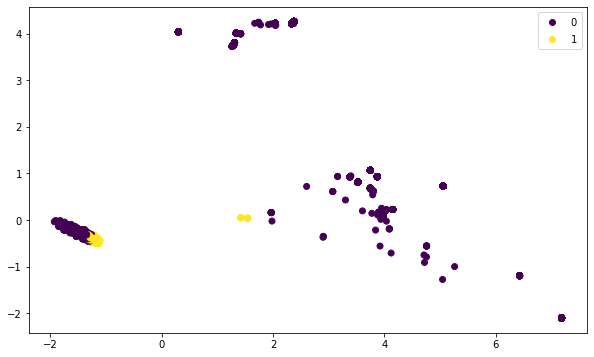

In [253]:
pca = PCA(n_components=2, random_state=0)
data_2d_pca = pca.fit_transform(logs_as_vectors)

pylab.figure(figsize=(10, 6))
scat = pylab.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], c=anomaly_scores_custom > 0.65*threshold_custom)
pylab.legend(*scat.legend_elements(num='auto'))